#### download a dataset from Kaggle

In [1]:
# First, install the Kaggle API client:
# !pip install kaggle

# to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Next, upload your Kaggle API key:
!mkdir -p ~/.kaggle
!echo '{"username":"ahmadsoliman94","key":"ffb7c90fc4521d202ca247af6493f9ad"}' > ~/.kaggle/kaggle.json

In [3]:
# Now you can download the dataset:
!kaggle datasets download -d abrambeyer/openintro-possum

/bin/bash: kaggle: command not found


#### unizip the dataset

In [4]:
import zipfile

# Open the zip file
with zipfile.ZipFile("openintro-possum.zip", "r") as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall("dataset/")

###### About the dataset: The possum data frame consists of nine morphometric measurements on each of 104 mountain brushtail possums, trapped at seven sites from Southern Victoria to central Queensland.


###### In this notebook, various machine learning algorithms will be applied and try to predict the total length of possums.

### Import the necessary libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score

import xgboost as xgb

#### Load the data into a Pandas DataFrame

In [6]:
df = pd.read_csv('dataset/possum.csv')

In [7]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


### Explore the data

In [8]:
df.describe()

,case,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,52.500000,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,30.166206,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,26.750000,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,52.500000,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,78.250000,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,104.000000,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


##### Encoding the features, that the datatypes of them is object

In [10]:
label_encoder = LabelEncoder()

objList = df.select_dtypes(include = "object").columns
df[objList] = df[objList].apply(label_encoder.fit_transform)

In [11]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,0,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,0,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,0,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,0,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


#### show the correlations between variables

<AxesSubplot:>

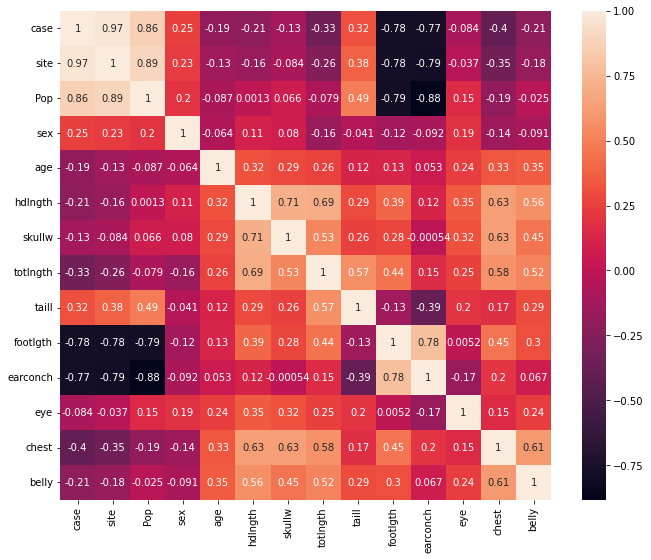

In [12]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap 
sns.heatmap(corr,annot=True)

##### show the variables that are correlated with the target >= 10% and drop the rest

In [13]:
corr_vars = corr[abs(corr['totlngth']) >= 0.10]['totlngth'].index
print(corr_vars)

Index(['case', 'site', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')


In [14]:
df = df[corr_vars]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   sex       104 non-null    int64  
 3   age       102 non-null    float64
 4   hdlngth   104 non-null    float64
 5   skullw    104 non-null    float64
 6   totlngth  104 non-null    float64
 7   taill     104 non-null    float64
 8   footlgth  103 non-null    float64
 9   earconch  104 non-null    float64
 10  eye       104 non-null    float64
 11  chest     104 non-null    float64
 12  belly     104 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 10.7 KB


#### Check for missing values and handle them

In [16]:
df.isnull().sum()

case        0
site        0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [17]:
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [18]:
df.isnull().sum()

case        0
site        0
sex         0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64

##### pairplot to visualize the relationships between variables and identify any trends or patterns in the data.

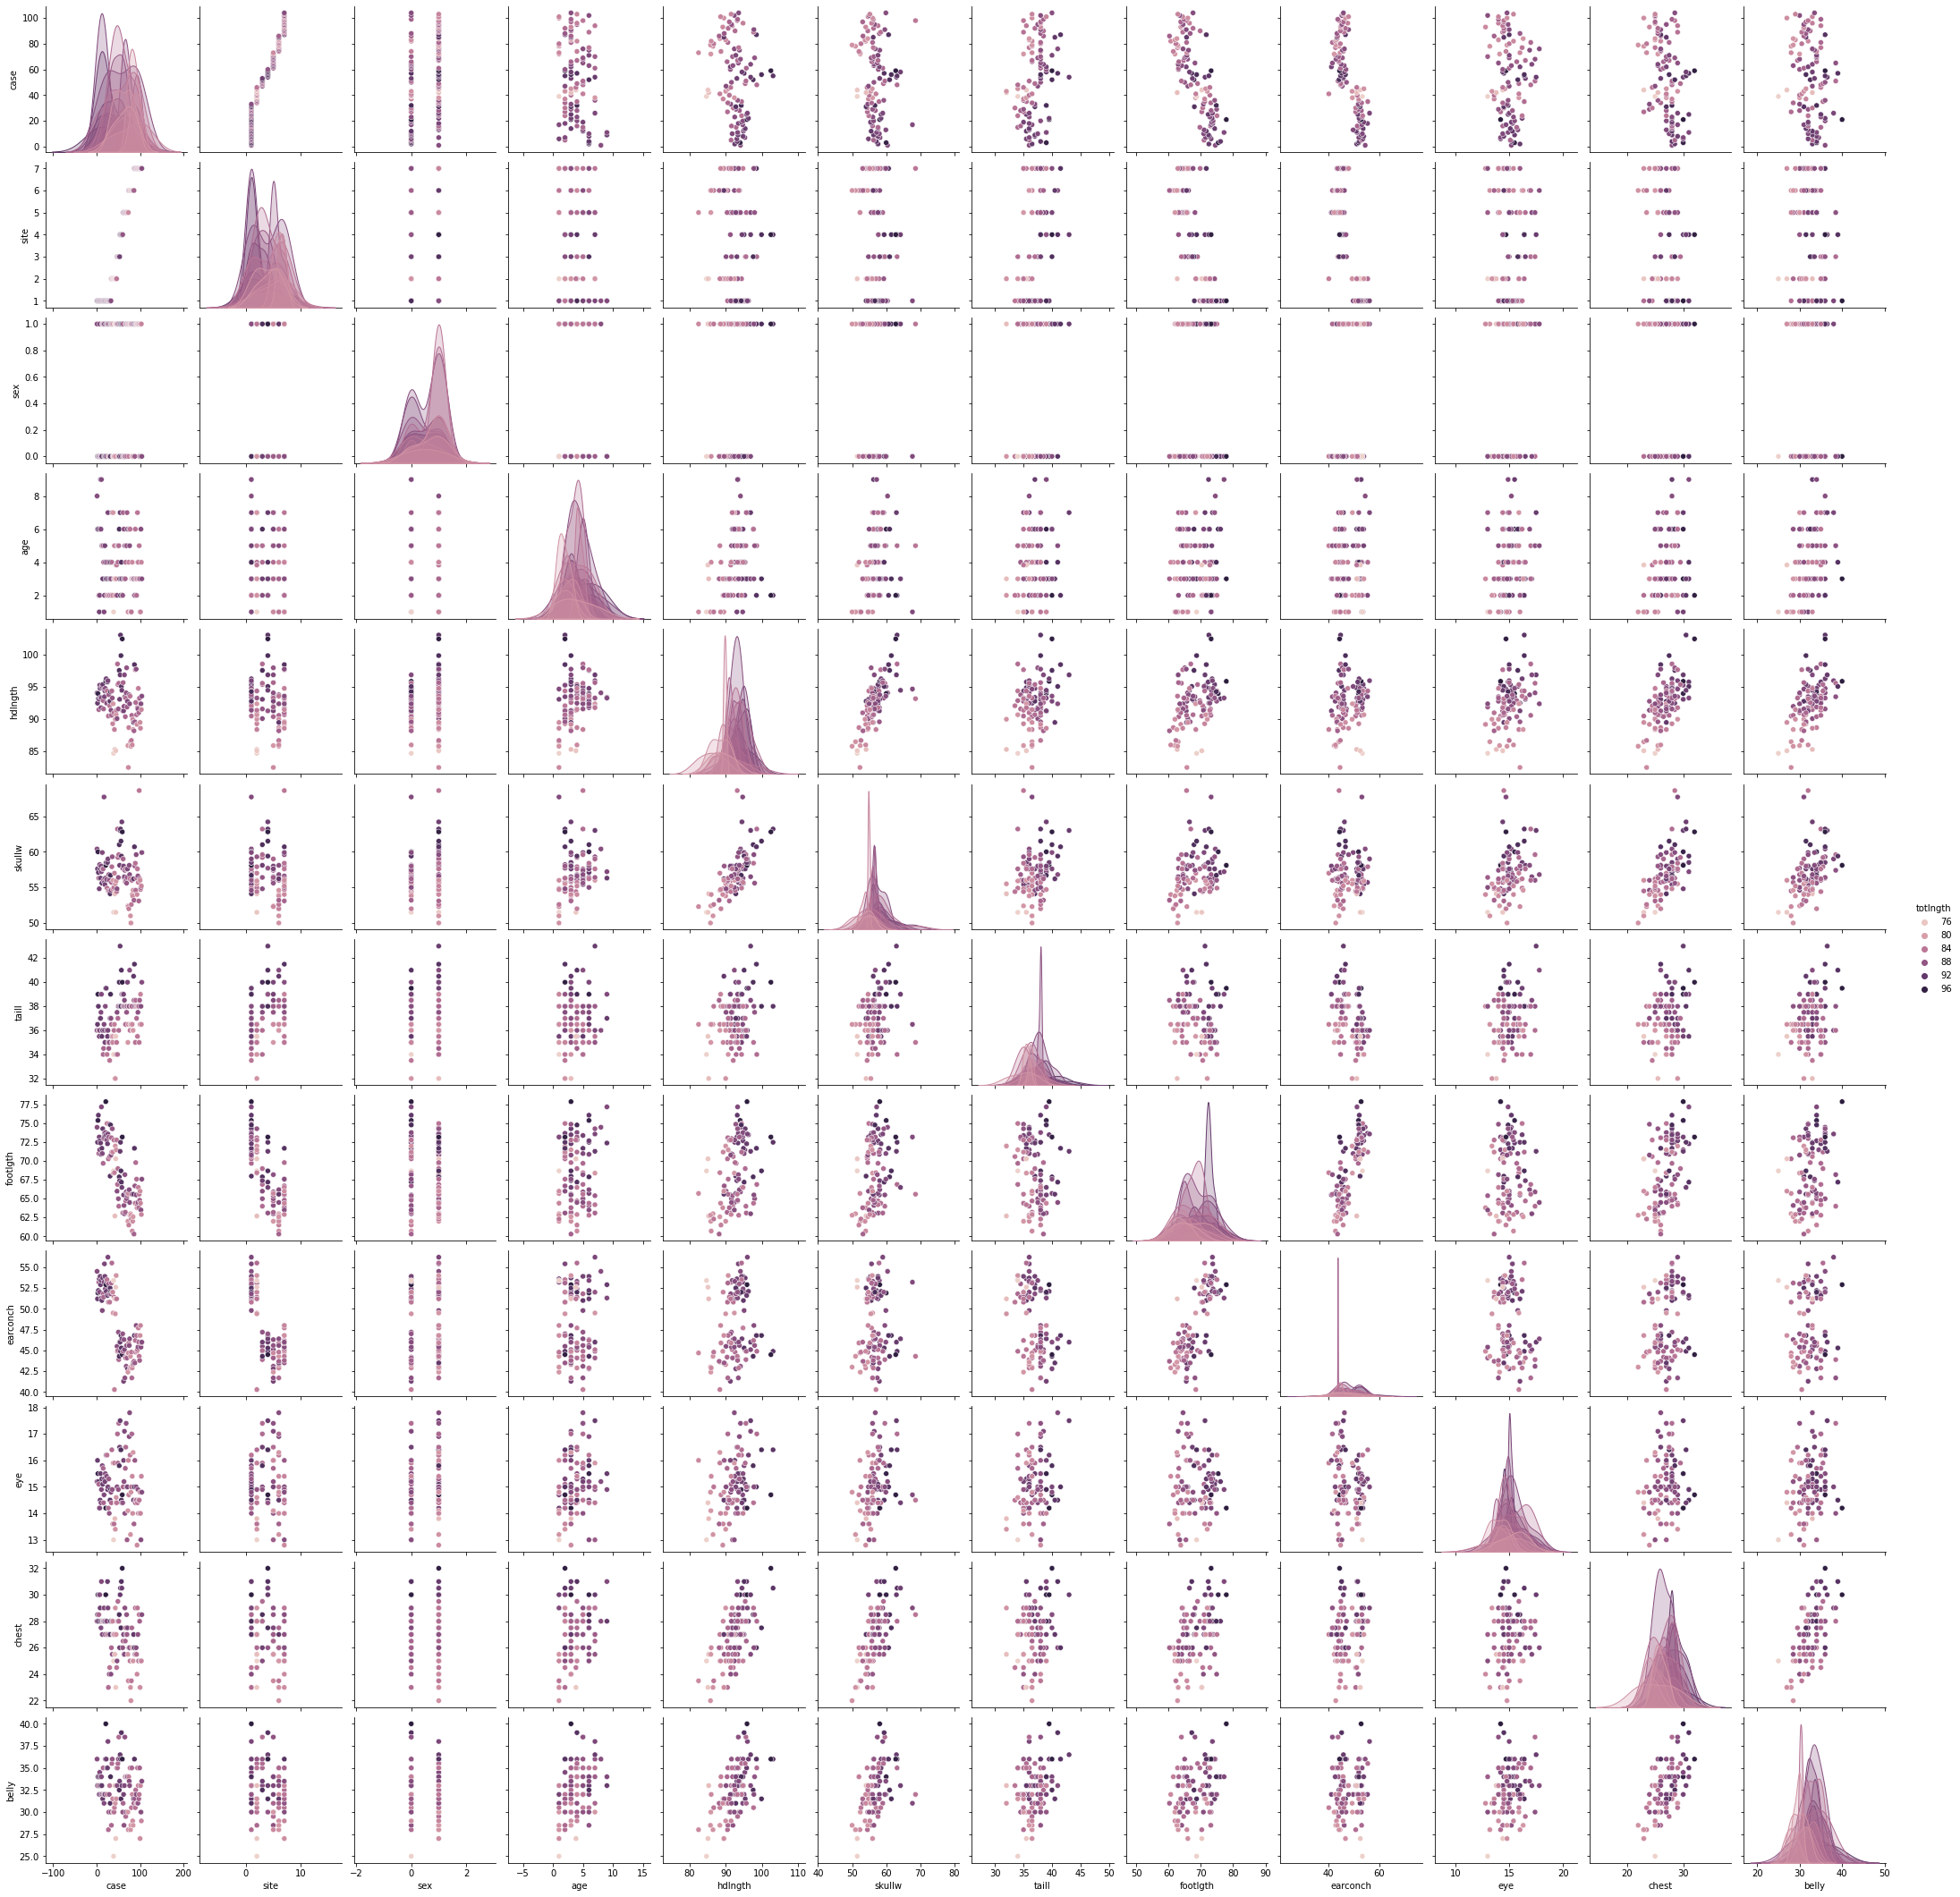

In [19]:
# Create the pairplot
sns.pairplot(df,hue='totlngth')

#### check the outliers 



In [20]:
# Loop through each column in the DataFrame
for col in df.columns:
    # Compute the mean and standard deviation of the column
    mean = df[col].mean()
    std = df[col].std()
  
    # identifies the outliers as observations that are more than 3 standard deviations away from the mean.
    outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)]
  
    # Print the number of outliers
    print(f'Number of outliers in {col}: {len(outliers)}')

Number of outliers in case: 0
Number of outliers in site: 0
Number of outliers in sex: 0
Number of outliers in age: 0
Number of outliers in hdlngth: 0
Number of outliers in skullw: 2
Number of outliers in totlngth: 0
Number of outliers in taill: 1
Number of outliers in footlgth: 0
Number of outliers in earconch: 0
Number of outliers in eye: 0
Number of outliers in chest: 0
Number of outliers in belly: 0


#### Check for duplicated rows

In [21]:
duplicated_rows = df.duplicated(subset=df.columns, keep=False)

# Print the duplicated rows
print(df[duplicated_rows])

Empty DataFrame
Columns: [case, site, sex, age, hdlngth, skullw, totlngth, taill, footlgth, earconch, eye, chest, belly]
Index: []


#### Split the data into train and test

In [22]:
X = df.drop('totlngth', axis=1)
y = df['totlngth']

In [23]:
X.shape, y.shape

((104, 12), (104,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(f'Shape of X train: {X_train.shape}')
print(f'Shape of y train: {y_train.shape}')
print(f'Shape of X test: {X_test.shape}')
print(f'Shape of y test: {y_test.shape}')

Shape of X train: (93, 12)
Shape of y train: (93,)
Shape of X test: (11, 12)
Shape of y test: (11,)


#### Selecting models

##### Linear Regression:

In [25]:

# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Set up the hyperparameter grid to search over
param_grid = {'model__fit_intercept': [True, False]}

# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
linear_predictions = best_model.predict(X_test)
r2_lin = r2_score(y_test, linear_predictions)
print("R2 score:", r2_lin)

Best hyperparameters: {'model__fit_intercept': True}
R2 score: 0.848961119551137


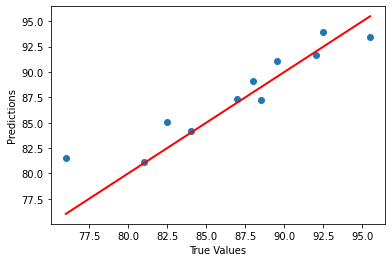

In [26]:
# Plot the predictions against the true values
plt.scatter(y_test, linear_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#### Decision Tree Regressor

In [27]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [28]:
# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

# Set up the hyperparameter grid to search over
param_grid = {
    'model__criterion': ['squared_error','absolute_error'],
    'model__max_depth':[None,2,3,4],
    'model__splitter':['best','random']
             }

# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
ds_tree_predictions = best_model.predict(X_test)
r2_ds_tree = r2_score(y_test, ds_tree_predictions)
print("R2 score:", r2_ds_tree)

Best hyperparameters: {'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__splitter': 'best'}
R2 score: 0.7996291980309782


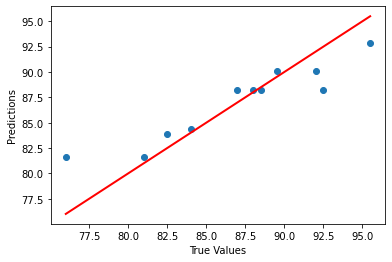

In [29]:
# Plot the predictions against the true values
plt.scatter(y_test, ds_tree_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

##### K-Neighbors Regressor

In [30]:
# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

# Set up the hyperparameter grid to search over
param_grid = {
    'model__weights': ['uniform','distance'],
    'model__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__p':[1,2],
    'model__leaf_size':[30,40,50]
             }

# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
knn_predictions = best_model.predict(X_test)
r2_knn = r2_score(y_test, knn_predictions)
print("R2 score:", r2_knn)

Best hyperparameters: {'model__algorithm': 'auto', 'model__leaf_size': 30, 'model__p': 1, 'model__weights': 'distance'}
R2 score: 0.7058903782906438


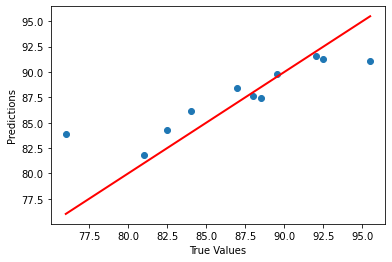

In [31]:
# Plot the predictions against the true values
plt.scatter(y_test, knn_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

##### SVM Regressor

In [32]:
# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

# Set up the hyperparameter grid to search over
param_grid = {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'model__degree':[2,3,4,5,6],
    'model__gamma':['scale','auto'],
    'model__C':[1.0,1.5,2.0],
    'model__max_iter':[-1,10,20,30]
             }


# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
svm_predictions = best_model.predict(X_test)
r2_svm = r2_score(y_test, svm_predictions)
print("R2 score:", r2_svm)

Best hyperparameters: {'model__C': 1.0, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__max_iter': -1}
R2 score: 0.8442058113057158


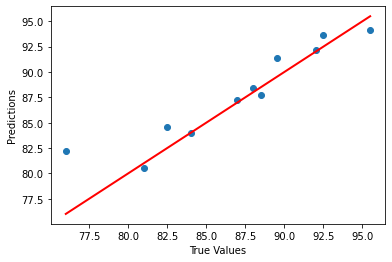

In [33]:
# Plot the predictions against the true values
plt.scatter(y_test, svm_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Random Forest Regressor

In [34]:
# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

# Set up the hyperparameter grid to search over
param_grid = {
    'model__n_estimators': [100,200,300,500],
    'model__criterion':['squared_error','absolute_error'],
    'model__max_depth':[10,20,40,50],
    'model__max_features':['sqrt','log2',None]
             }


# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
rf_predictions = best_model.predict(X_test)
r2_rf = r2_score(y_test, rf_predictions)
print("R2 score:", r2_rf)

Best hyperparameters: {'model__criterion': 'squared_error', 'model__max_depth': 40, 'model__max_features': None, 'model__n_estimators': 100}
R2 score: 0.835767234144284


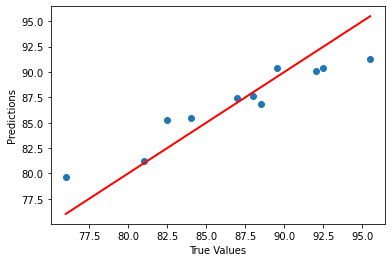

In [35]:
# Plot the predictions against the true values
plt.scatter(y_test, rf_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### XGB Regressor

In [36]:
# Set up the pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())
])

# Set up the hyperparameter grid to search over
param_grid = {
    'model__booster': ['gbtree','gblinear','dart'],
    'model__eta':[0.01,0.02,0.3,0.003],
    'model__objective': ['reg:squarederror','reg:absoluteerror']
             }


# Set up the K-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the model using the best hyperparameters
xgb_predictions = best_model.predict(X_test)
r2_xgb = r2_score(y_test, xgb_predictions)
print("R2 score:", r2_xgb)

Best hyperparameters: {'model__booster': 'gblinear', 'model__eta': 0.3, 'model__objective': 'reg:squarederror'}
R2 score: 0.8436405420034989


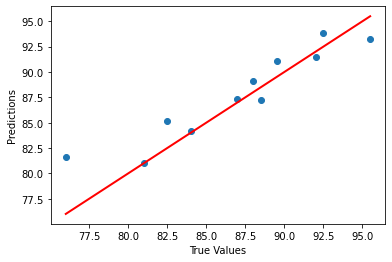

In [37]:
# Plot the predictions against the true values
plt.scatter(y_test, xgb_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [38]:
scores = [r2_lin,r2_ds_tree,r2_knn,r2_svm,r2_rf,r2_xgb]
labels = ['Linear Regressor', 'Decision Tree Regressor', 'K-Neighbors Regressor', 'SVM Regressor','Random Forest Regressor','XGB Regressor']
accs = {'R^2 Score': scores}
df = pd.DataFrame(accs,index=labels)
df

,R^2 Score
Linear Regressor,0.848961
Decision Tree Regressor,0.799629
K-Neighbors Regressor,0.705890
SVM Regressor,0.844206
Random Forest Regressor,0.835767
XGB Regressor,0.843641


<AxesSubplot:>

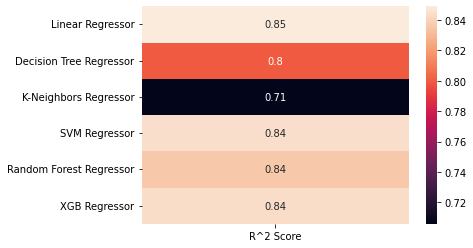

In [39]:
sns.heatmap(df,annot=True)